In [10]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import fsolve

Import Data

In [11]:
#Daily equity price and the risk free rate
df = pd.read_excel('FE_Price.xlsx')
treasury_bill = pd.read_excel('DTB3.xlsx')

In [12]:
#change x to date
df['Date'] = pd.to_datetime(df['Date'])
treasury_bill['observation_date'] = pd.to_datetime(treasury_bill['observation_date'])
treasury_bill = treasury_bill.rename(columns={'observation_date': 'Date'})

#merge dataframe
df = pd.merge(df, treasury_bill, on='Date', how='left')

#fill na with previous value
df = df.fillna(method='ffill')

#Rename dataset
df = df.rename(columns={'DTB3': 'tssr'})

#Data slice
df_2015 = df[df['Date'].dt.year == 2015]
df_2015 = df_2015[::-1]
df_2015.reset_index(drop=True, inplace=True)

In [13]:
#Oustanding Shares
outstanding_shares = 421100000

#Debt
debt = 1/2 * 34163000000 + 5602000000

#Equity value
df_2015['St'] = df_2015['Last Price'] * outstanding_shares

#Initial value of equity
initial_equity = df_2015['St'].iloc[0]

#Initial value of rfr
initial_rfr = df_2015['tssr'].iloc[0]

#Return 
df_2015['Equity Return'] = np.log(df_2015['St'] / df_2015['St'].shift(1))

#column number
n = len(df_2015)

#Horizon
T = 1

Define Black-Scholes-Merton Formula

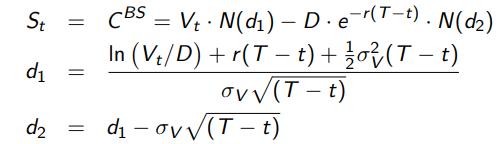

In [14]:
# Define the Black-Scholes option price function
def black_scholes_option_price(sigma, S, K, T, r):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

# Define the function to find the difference between market and Black-Scholes prices
def implied_equity(S, market_price, K, T, r, sigma):
    return black_scholes_option_price(sigma, S, K, T, r) - market_price

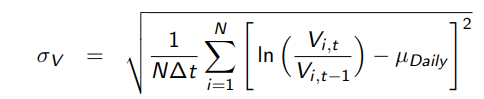

In [15]:
# Calculate initial Vt_vol
vol_0 = (df_2015['Equity Return'].std() * np.sqrt(n) * initial_equity / (initial_equity + debt)) 

# Initialize an empty list to store vol values
vol_values = []

# Initialize residual and iteration counter
residual = float('inf')
iteration = 0

# Loop until the residual is less than 0.0001
while residual > 0.0000001:
    # Initialize an array to store the results
    asset_value = np.zeros(len(df_2015))

    # Find stock price using fsolve
    for i in range(n):
        # Solve for stock price using fsolve
        result = fsolve(implied_equity, df_2015['St'].iloc[i] + debt, args=(df_2015['St'].iloc[i], debt, T, df_2015['tssr'].iloc[i], vol_0))
        asset_value[i] = result[0]  # Assign the solution to the appropriate index

    # Add the value of asset "Vt"
    df_2015['Vt'] = asset_value

    # Calculate daily Vt return
    df_2015['Vt return'] = np.log(df_2015['Vt'] / df_2015['Vt'].shift(1))
    vt_return = df_2015['Vt return'].mean()

    # Calculate volatility n
    df_2015['vol_calc'] =  (df_2015['Vt return'] - vt_return) ** 2
    vol_1 = (df_2015['vol_calc'].sum() * n / (n - 1)) ** 0.5

    # Calculate residual
    residual = abs(vol_1 - vol_0)
    print(f"Iteration {iteration + 1}: Residual = {residual}")

    # Append vol_1 to vol_values
    vol_values.append(vol_1)

    # Update vol_0 for the next iteration
    vol_0 = vol_1

    # Increment iteration counter
    iteration += 1

print("Convergence achieved.")

Iteration 1: Residual = 0.0832428555612081
Iteration 2: Residual = 8.007388767292123e-05
Iteration 3: Residual = 3.1200004493858735e-07
Iteration 4: Residual = 1.2140466409960027e-09
Convergence achieved.


defaul probability via closed form solution

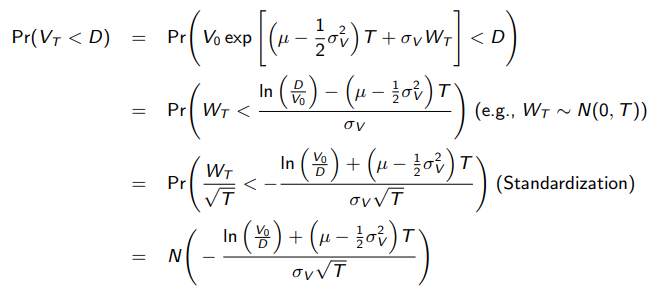

In [16]:
#calculate firm default probability
d1 = (np.log(initial_equity / debt) + (initial_rfr + 0.5 * vol_0**2) * T) / (vol_0 * np.sqrt(T))
default_probability = norm.cdf(d1)

In [17]:
print(f"Default probability = {default_probability}")

Default probability = 0.05440150133819529
